In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=3)

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# sk dependencies
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor

import scipy
from scipy import stats

import skopt
from skopt.space import Space
from skopt.sampler import Lhs

In [2]:
df = pd.read_csv('data.csv')
df

,Compression Strength (MPa),Compression Modulus (MPa),Toughness (GPa),A (wt%),B (wt%),C (wt%),D (wt%),E (wt%),F (wt%)
0,455,1.37,68113,0,18,21,28,20,13
1,280,2.11,51731,0,2,38,4,29,27
2,470,1.76,77877,19,30,10,6,7,28
3,440,1.96,76655,8,16,14,4,19,39
4,366,1.23,62118,34,6,23,16,19,2
...,...,...,...,...,...,...,...,...,...
138,558,1.15,81235,34,36,0,0,20,10
139,500,1.68,86776,39,23,0,0,0,38
140,502,1.65,86185,37,22,0,1,0,40
141,498,1.68,87186,41,21,0,1,0,37


In [3]:
x_list = df.columns[3:]
obj_list = df.columns[:3]
train_X = df[x_list].to_numpy()
train_y = df[obj_list].to_numpy()

xscaler = MinMaxScaler()
transformed_X = xscaler.fit_transform(train_X)

yscaler = MinMaxScaler() # we use this because it is easier to optimize on compared to power transform
transformed_y = yscaler.fit_transform(train_y)

In [4]:
'''
we start off with a simple RF regressor
'''

rf = RandomForestRegressor(n_estimators=500, random_state=1).fit(transformed_X, transformed_y)
y_pred = rf.predict(transformed_X)

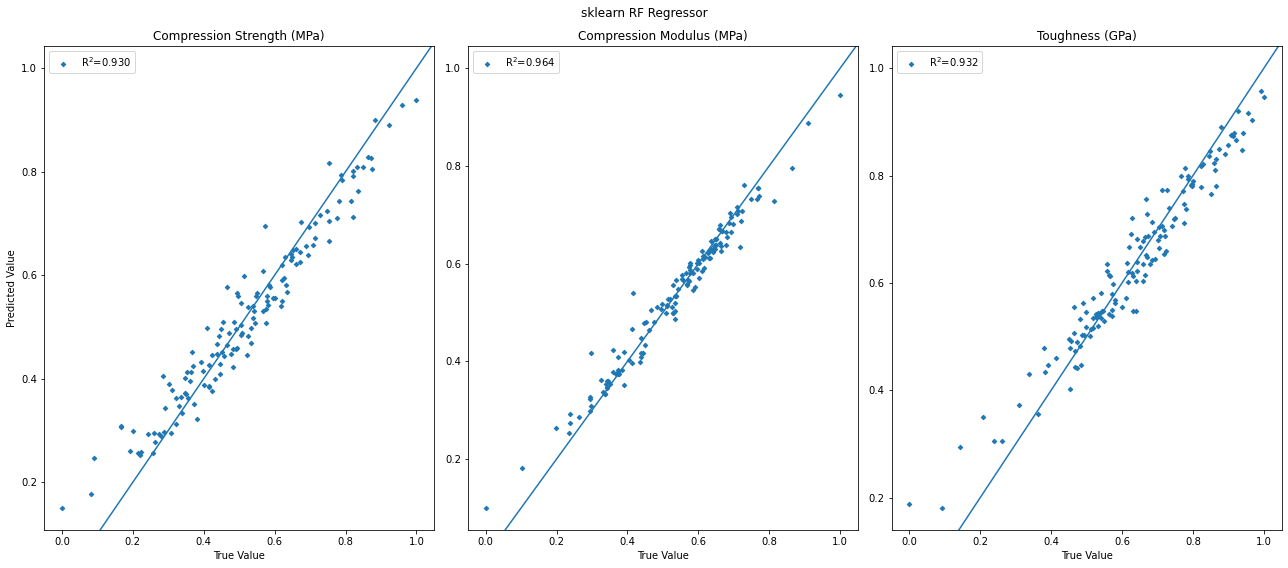

In [5]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,8))

for i in range(len(obj_list)):
    y_true = transformed_y[:,i]
    y_test = y_pred[:,i]
    
    ''' 
    ax.errorbar(x=y_true, y=y_pred, ls='', marker='o', mec='w', 
                mew=0.5, alpha =0.2)
    '''

    ax[i].axline((1, 1), slope=1)
        
    r2 = metrics.r2_score(y_true, y_test)
    ax[i].scatter(x=y_true, y=y_test, #yerr=yerr, ls='', 
                  marker='D', s=10, #c=c,
                  label='R$^2$={:.3f}'.format(r2),
                 )
    ax[i].set_title(obj_list[i])
    ax[i].set_xlabel('True Value')
    ax[i].legend(loc='upper left')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('sklearn RF Regressor')
fig.tight_layout()

In [6]:
'''
to perform data augmentation, we virtually generate 1000 samples with LHS
these samples are fed into the RF regressor which has good interpolation, and used to train a GP regressor
the idea behind using GP is that decision tree based models are stepped and irregular
thus, we form a smooth output surface that 'should' approximate the ground truth fairly well

furthermore, the data undergoes preprocessing since GPs are quite sensitive to data scaling and distribution
'''

lhs = Lhs(criterion="maximin", iterations=1000)
space = Space([(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)])
x = lhs.generate(space.dimensions, 1000)

# enforce 100% sum
virtual_x = np.array(x)
for i in range (virtual_x.shape[0]):
    virtual_x[i] = virtual_x[i]/(virtual_x[i].sum()/1)

virtual_y = rf.predict(virtual_x)

In [9]:
'''
we set a relatively simple kernel with Matern and noise, and then train up our GP regressors
'''

target_dict = {'CS': 'Compression Strength (MPa)',
               'CM': 'Compression Modulus (MPa)', 
               'TS': 'Toughness (GPa)'
              }

gp_dict = {}
pred_dict = {}
std_dict = {}

print("Training...")

for key, i in zip(target_dict.keys(), range(len(obj_list))):
    print(key)
    
    kernel = ConstantKernel(1.0, constant_value_bounds='fixed') * Matern(nu=2.5) + WhiteKernel(noise_level=1)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer=5).fit(virtual_x, virtual_y[:,i])
    
    y_pred, std = gpr.predict(virtual_x, return_std=True)
    
    gp_dict[key] = gpr
    pred_dict[key] = y_pred
    std_dict[key] = std
    
print("Done!")

Training...
CS
CM
TS
Done!


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


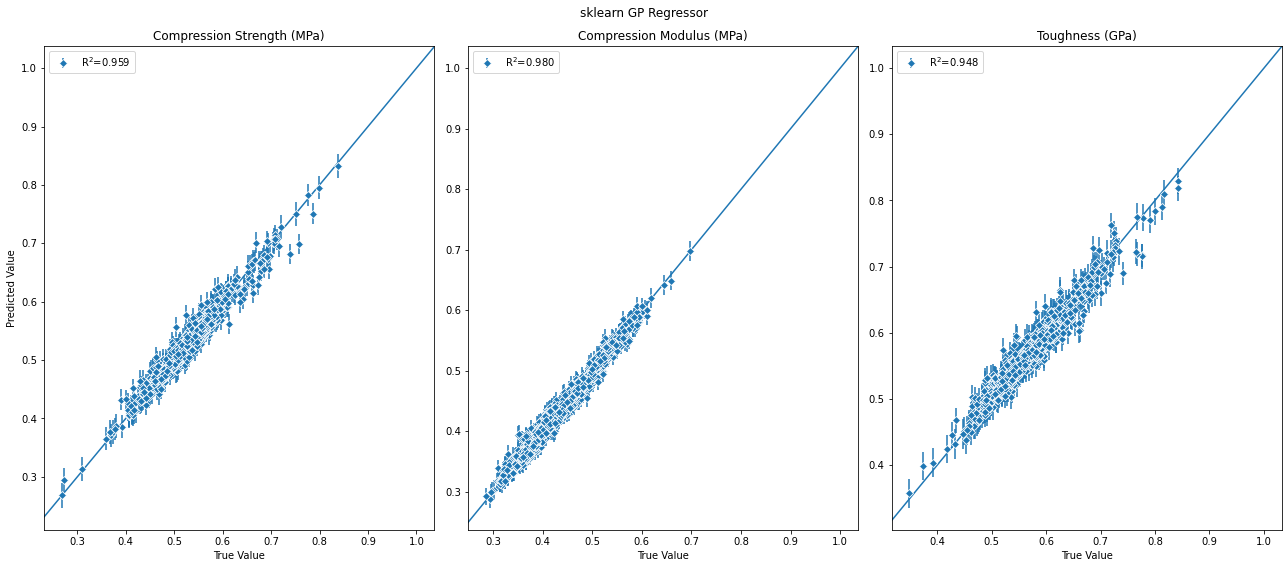

In [10]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,8))

for key, i in zip(target_dict.keys(), range(len(obj_list))):
    y_true = virtual_y[:,i]
    y_test = pred_dict[key]
    y_err = std_dict[key]

    ax[i].axline((1, 1), slope=1)
        
    r2 = metrics.r2_score(y_true, y_test)
    ax[i].errorbar(x=y_true, y=y_test, yerr=y_err, ls='', 
                   marker='D', mec='w', mew=0.8, ms=5,
                   label='R$^2$={:.3f}'.format(r2),
                  )
    ax[i].set_title(obj_list[i])
    ax[i].set_xlabel('True Value')
    ax[i].legend(loc='upper left')
    
ax[0].set_ylabel('Predicted Value')
fig.suptitle('sklearn GP Regressor')
fig.tight_layout()

In [11]:
joblib.dump(gp_dict, 'gp_dict') 
joblib.dump(xscaler, 'xscaler') 
joblib.dump(yscaler, 'yscaler') 

['yscaler']